# Homework 9-2

- Work an absorption-only problem
    - 5 mean free paths thick slab
    - Isotropic flux on left boundary (for incoming directions) with current of 1
        - Use Step, Diamond Difference, and Weighted with $\alpha=0.8$
        - Use $S_4$, $S_8$, $S_{12}$
        - Use as fine a spatial discretization as required for convergence
    - Analytic outgoing current on the right boundary is $2 E_3(5) = 1.755e-3$ (see App A)
    - Check accuracy vs. spatial discretization, auxiliary equation used, angular quadrature
- Extra credit: What would be the optimum value of $\alpha_n$

In [150]:
from scipy.special import legendre, expn
from scipy.integrate import trapz
import numpy as np
import matplotlib.pyplot as plt

Configure parameters

In [151]:
num_sections = 10
t = 50
sigma = 5 / t
dx = t / num_sections
nang = 4

Auxiliary equations: these describe the average flux in terms of the flux at the edges

Step:

$$ 
\psi_{n,i+\frac{1}{2}} = \frac{\bar{S}_{n,i} + \frac{\mu_n}{\delta x_i} \psi_{n, i-\frac{1}{2}}}{\frac{\mu_n}{\delta x_i} + \sigma_{ti}}
$$
$$
\phi_{i \ell} = \sum_{n=1}^N w_n \bar{\psi}_{n,i} P_\ell (\mu_n)
$$

In [152]:
def step(psi_minus, mu, s, dx, sigma):
    mux = mu / dx
    
    num = s + mux * psi_minus
    den = mux + sigma
    
    psi_plus = num / den
    
    psi_avg = psi_plus
    
    return psi_avg, psi_plus

Diamond Difference:

$$
\psi_{n,i+\frac{1}{2}} = 
\frac{
  \bar{S}_{n,i} 
      + 
  \left( 
    \frac{
      \mu_n
    }{
      \delta x_i
    } 
      - 
    \frac{
      \sigma_{ti}
    }{
      2
    } 
  \right) \psi_{n, i-\frac{1}{2}}
}
{
  \frac{
    \mu_n
  }{
    \delta x_i
  } 
    + 
  \frac{
    \sigma_{ti}
  }{
    2
  }
}
$$

In [153]:
def diamond_difference(psi_minus, mu, s, dx, sigma):
    mux = mu / dx
    hsig = sigma / 2
    
    psi_plus = s + (mux - hsig) * psi_minus
    psi_plus /= mux + sigma / 2
    
    psi_avg = (psi_minus + psi_plus) / 2
    
    return psi_avg, psi_plus

Weighted diamond difference:

$$
\psi_{n,i+\frac{1}{2}} = 
\frac{\bar{S}_{n,i}+ \left(\frac{\mu_n}{\delta x_i}-(1 - \alpha) \sigma_{ti}\right) \psi_{n, i-\frac{1}{2}}}{\frac{\mu_n}{\delta x_i} + \alpha \sigma_{ti}}
$$

In [154]:
def weighted_diamond_difference(psi_minus, mu, s, dx, sigma, alpha=0.8):
    mux = mu / dx
    
    psi_plus = s + (mux - (1 - alpha) * sigma) * psi_minus
    psi_plus /= (mux) + (alpha * sigma)
    
    psi_avg = (1 - alpha) * psi_minus + alpha * psi_plus
    
    return psi_avg, psi_plus

Since we know the incoming current on the left boundary, we will proceed from left to right

This is a one-group problem, so there is no need for outer iterations

Set $\mu$ and weight parameters for the quadrature

In [155]:
def set_quadrature(nang):
    wt = []
    mu = []

    if(nang==2):
        wt.append(1.)

        mu.append(.5773502691)

    elif(nang==4):
        wt.append(.6521451549)
        wt.append(.3478548451)

        mu.append(.3399810435)
        mu.append(.8611363115)

    elif(nang==8):
        wt.append(.3626837834)
        wt.append(.3137066459)
        wt.append(.2223810344)
        wt.append(.1012285363)

        mu.append(.1834346424)
        mu.append(.5255324099)
        mu.append(.7966664774)
        mu.append(.9602898564)

    elif(nang==12):
        wt.append(0.2491470458)
        wt.append(0.2334925365)
        wt.append(0.2031674267)
        wt.append(0.1600783286)
        wt.append(0.1069393260)
        wt.append(0.0471753364)

        mu.append(0.1252334085)
        mu.append(0.3678314989)
        mu.append(0.5873179542)
        mu.append(0.7699026741)
        mu.append(0.9041172563)
        mu.append(0.9815606342)
    
    #mus = np.array([-m for m in mu] + mu)
    #weights = np.array([w / 2 for w in wt] + [w / 2 for w in wt])
    
    mus = np.array(mu)
    weights = np.array(wt)
    
    try:
        assert(np.allclose(np.sum(weights), np.array(1.0)))
    except AssertionError as ae:
        print(np.sum(weights))
        raise ae
    
    mu.append(0.1252334085)
    mu.append(0.3678314989)
    mu.append(0.5873179542)
    mu.append(0.7699026741)
    mu.append(0.9041172563)
    mu.append(0.9815606342)

wt = [0.5*w for w in wt] + [0.5*w for w in wt]
mu = mu + [-m for m in mu]

Make function to calculate convergence after each `x` loop

In [156]:
def convergence_test(old_flux, new_flux, epsilon=0.00001):
    e_arr = np.abs(new_flux - old_flux) / new_flux
    return np.all(e_arr < epsilon)

Set initial fluxes

In [157]:
cell_function = step

In [158]:
old_flux = np.ones(num_sections) * 10000
new_flux = np.zeros(num_sections)

# Each cell has a left and right boundary flux
left = np.zeros(num_sections)
right = np.zeros(num_sections)
center = np.zeros(num_sections)

# Set the left boundary to 1
left[0] = 1.0

In [159]:
convergence_counter = 0
while not(convergence_test(old_flux, new_flux)) and convergence_counter < 1000000:
    convergence_counter += 1
    old_flux = np.copy(new_flux)
    for m, w in zip(mu, wt):
        for i in range(num_sections):
            if i == 0:
                left[i] = 1.0
            else:
                left[i] = right[i-1]
            center[i], right[i] = cell_function(center[i], m, 0, dx, sigma)
            new_flux[i] += w * left[i] * m

/Users/jrpowers-luhn/miniconda3/envs/579/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/Users/jrpowers-luhn/miniconda3/envs/579/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/jrpowers-luhn/miniconda3/envs/579/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


In [160]:
2*expn(3, 5)

0.0017556017855412775

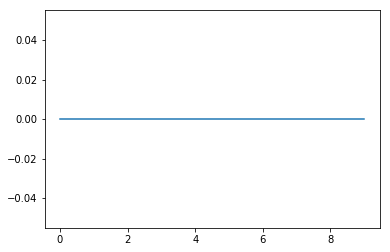

In [161]:
plt.plot(new_flux)
#plt.xscale('log')

In [162]:
left[0]

1.0

In [163]:
right[-1]

-0.0

In [164]:
convergence_counter

1000000

In [2]:
[i for i in range(5)][::-1]

[4, 3, 2, 1, 0]